In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import nmf, proximal, display, proximal_nmf
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

INFO:lsst.meas.deblender.proximal:Total parents: 41
INFO:lsst.meas.deblender.proximal:Unblended sources: 25
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 16


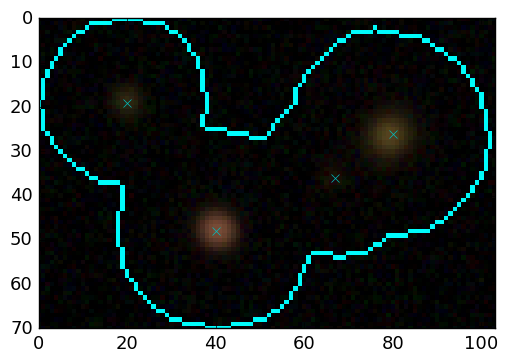

In [2]:
dataPath = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..','data', 'sim_data'))
filters = ["g","r", "i","z",'y']
imgFilename = os.path.join(dataPath, "test2/{0}_{1}.fits")
catFilename = os.path.join(dataPath, "test2/det_merge.fits")
simFilename = os.path.join(dataPath, "test2/catalog_true.fits")

expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename)
#display.plotColorImage(calexps=expDb.calexps, filterIndices=[2,1,0], contrast=1, figsize=(8,8));
condition = expDb.mergedTable["peaks"]==4
#condition = (expDb.mergedTable["peaks"]>2) & (expDb.mergedTable["peaks"]<10)
footprint, peaks = expDb.getParentFootprint(parentIdx=0, condition=condition, contrast=1)
deblend = proximal.DeblendedParent(expDb, footprint, peaks)

In [3]:
psf = expDb.calexps[0].getPsf().computeImage().getArray()

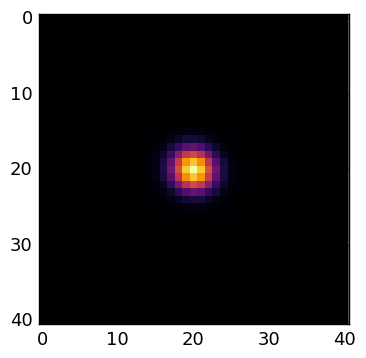

In [4]:
plt.imshow(psf)

In [94]:
from lsst.meas.deblender.proximal_nmf import getOffsets, getPSFOp
import scipy.sparse

def getTranslationOp(deltaX, deltaY, shape, threshold=1e-8):
    Dx, Dy = int(deltaX), int(deltaY)
    dx = np.abs(deltaX-Dx)
    dy = np.abs(deltaY-Dy)
    
    height, width = shape
    size = width * height
    
    # If dx or dy are less than the shift threshold, set them to zero
    if dx < threshold:
        Dx = np.ceil(deltaX)
        dx = 0
    if dy < threshold:
        Dy = np.ceil(deltaY)
        dy = 0
    
    # Create the operators to transform a pixels neighbors
    tx = np.identity(3)*(1-dx)
    ty = np.identity(3)*(1-dy)
    if deltaX>0:
        np.fill_diagonal(tx[:,1:], dx)
    elif deltaX<0:
        np.fill_diagonal(tx[1:,:], dx)
    if deltaY>0:
        np.fill_diagonal(ty[:,1:], dy)
    elif deltaY<0:
        np.fill_diagonal(ty[1:,:], dy)
    
    # Transform the neighbors to the transformed values
    neighbors = np.zeros((3,3))
    neighbors[1,1] = 1
    neighbors = ty.dot(neighbors.dot(tx))
    
    # The rest is constructed exactly like the PSF,
    # so just use that here instead
    transOp = getPSFOp(neighbors, shape, 1e-9)
    
    return neighbors, (tx,ty), transOp

shape = (10,20)
testImg = np.zeros(shape)
testImg[5,5] = 2
a,b,t = getTranslationOp(.5,-.5, (10,20))
print(a)
print(b[0])
print(b[1])
print(b[1].dot(b[0]))
t

[[ 0.    0.    0.  ]
 [ 0.    0.25  0.25]
 [ 0.    0.25  0.25]]
[[ 0.5  0.5  0. ]
 [ 0.   0.5  0.5]
 [ 0.   0.   0.5]]
[[ 0.5  0.   0. ]
 [ 0.5  0.5  0. ]
 [ 0.   0.5  0.5]]
[[ 0.25  0.25  0.  ]
 [ 0.25  0.5   0.25]
 [ 0.    0.25  0.5 ]]


<200x200 sparse matrix of type '<type 'numpy.float64'>'
	with 741 stored elements in COOrdinate format>

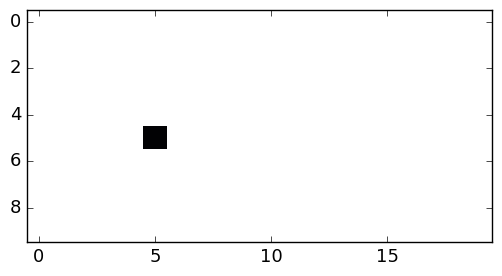

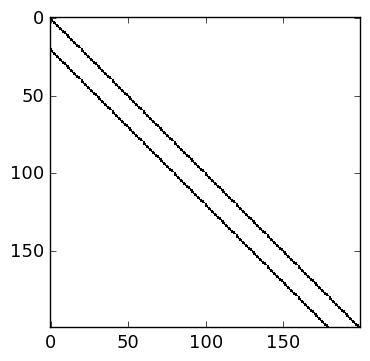

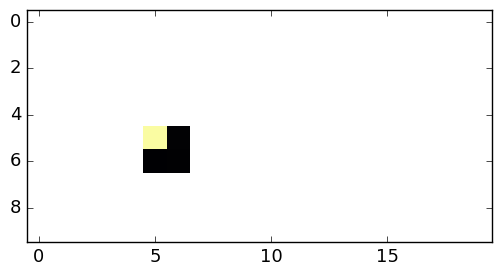

<module 'matplotlib.pyplot' from '/Users/fred/lsst/code/lsstswig2/miniconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [95]:
display.maskPlot(testImg, hideAxes=False)
display.maskPlot(t.toarray(), hideAxes=False)
tt = t.dot(testImg.flatten()).reshape(testImg.shape)
display.maskPlot(testImg+40*tt, hideAxes=False)

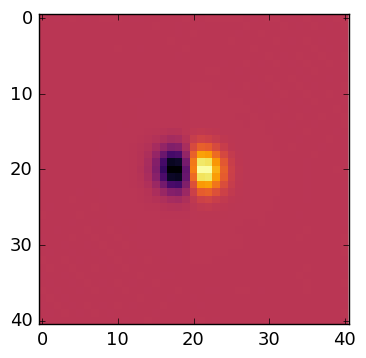

In [108]:
a,b,t = getTranslationOp(.9,0, psf.shape)
tp = t.dot(psf.flatten()).reshape(psf.shape)
np.max(psf-tp)
plt.imshow(psf-tp)

In [61]:
from lsst.meas.deblender.proximal_nmf import adapt_PSF
def getPsfOperators(P, B, shape, threshold=1e-2, diffThresh=1e-4):
    psf = P[1:-1,1:-1]
    mask = psf<threshold
    
    dxPsf = P[1:-1, :-2]-P[1:-1, 2:]
    dyPsf = P[:-2, 1:-1]-P[2:, 1:-1]
    dxPsf[np.abs(dxPsf)<diffThresh] = 0
    dyPsf[np.abs(dyPsf)<diffThresh] = 0
    
    psfOp = adapt_PSF(psf, B, shape, threshold)
    dxPsfOp = adapt_PSF(dxPsf, B, shape, -100)
    dyPsfOp = adapt_PSF(dyPsf, B, shape, -100)
    return psfOp, dxPsfOp, dyPsfOp, (psf, dxPsf, dyPsf, mask)

_, _, _, (p, px, py, pm) = getPsfOperators(psf.computeImage().getArray(), 5, (20,20))

INFO:lsst.meas.deblender.proximal_nmf:Total psf pixels: 37
INFO:lsst.meas.deblender.proximal_nmf:Total psf pixels: 80
INFO:lsst.meas.deblender.proximal_nmf:Total psf pixels: 82


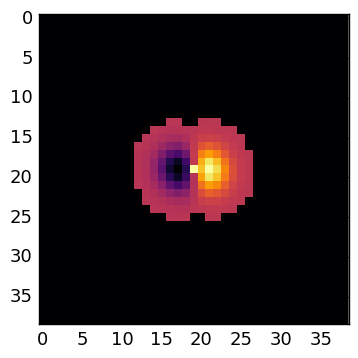

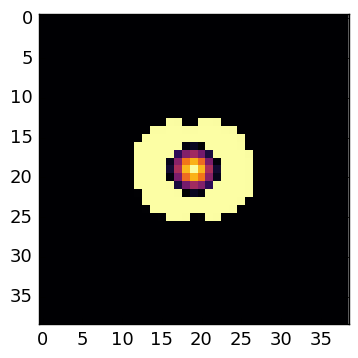

In [62]:
mask = ~(px==0) | ~pm
plt.imshow(mask)
plt.imshow(np.ma.array(px, mask=px==0))
plt.show()
plt.imshow(mask)
plt.imshow(np.ma.array(p, mask=pm))

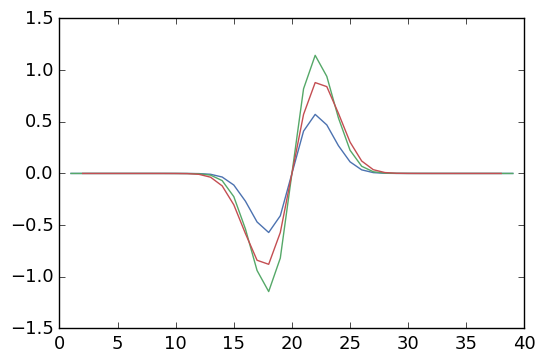

In [4]:
psfVec = psf.computeKernelImage().getArray().flatten()
psfImg = psf.computeKernelImage().getArray()

dx = psfImg[1:-1,:-2]-psfImg[1:-1,2:]
dy = psfImg[:-2,1:-1]-psfImg[2:,1:-1]
d0 = psfImg[1:-1]

dx2 = psfImg[2:-2,:-4]-psfImg[2:-2,4:]
dy2 = psfImg[:-4,2:-2]-psfImg[4:,2:-2]
d02 = psfImg[2:-2]

norm = np.max(psfImg)
plt.plot(range(1,len(dx)+1), dx[19]/norm)
plt.plot(range(1,len(dx)+1), 2*dx[19]/norm)
plt.plot(range(2, len(dx2)+2), dx2[18]/norm)
#plt.plot(2*dx2[18])